# plaq-u-net: multi-patch consensus U-Net for automated detection and segmentation of the carotid arteries on black blood MRI sequences

E. Lavrova, 2022  
  
This is a code supporting the corresponding paper.

Packages import:

In [1]:
import os
import numpy as np
from os import listdir
from xml.etree import ElementTree
from numpy import zeros
from numpy import asarray
from numpy import expand_dims
from numpy import mean
import pydicom
import random
import matplotlib.pyplot as plt
import glob
import matplotlib.patches as patches

import cv2

from tqdm import tqdm_notebook, tnrange
from itertools import chain

import keras

import random
import pandas as pd

plt.style.use("ggplot")

Using TensorFlow backend.
C:\Users\E.Lavrova\.conda\envs\lisa_tf1\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\E.Lavrova\.conda\envs\lisa_tf1\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\E.Lavrova\.conda\envs\lisa_tf1\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\E.Lavrova\.conda\envs\lisa

In [2]:
import warnings
warnings.filterwarnings('ignore')

GPU assignment:

In [3]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = '5,6'                        
import tensorflow as tf
import keras.backend as K
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
tf.compat.v1.keras.backend.set_session(tf.compat.v1.Session(config=config))
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0',
 '/job:localhost/replica:0/task:0/device:GPU:1']

## 1. Data load

In [4]:
sub_names_train = ['AMC008', 'AMC003', 'AMC011', 'AMC010', 'AMC014', 'AMC013', 'AMC002', 'AMC001', 'AMC018', 'MUMC084', 
                   'MUMC072', 'MUMC002', 'MUMC030', 'MUMC065', 'MUMC010', 'MUMC031', 'MUMC037', 'MUMC111', 'MUMC009', 'MUMC013',
                   'MUMC033', 'MUMC056', 'MUMC082', 'MUMC035', 'MUMC119', 'MUMC040', 'MUMC118', 'MUMC089', 'MUMC060', 'MUMC074',
                   'MUMC011', 'MUMC048', 'MUMC120', 'MUMC077', 'MUMC044', 'MUMC068', 'MUMC001', 'MUMC125', 'MUMC105', 'MUMC055',
                   'MUMC098', 'MUMC073', 'MUMC026', 'MUMC099', 'MUMC101', 'MUMC075', 'MUMC100', 'MUMC076', 'MUMC121', 'MUMC050',
                   'MUMC061', 'MUMC092', 'MUMC017', 'MUMC109', 'MUMC091', 'MUMC129', 'MUMC016', 'MUMC067', 'MUMC045', 'MUMC096',
                   'MUMC028', 'MUMC020', 'MUMC095', 'MUMC003', 'MUMC117', 'MUMC106', 'MUMC122', 'MUMC019', 'MUMC085', 'MUMC046',
                   'MUMC116', 'MUMC057', 'MUMC090', 'MUMC110', 'MUMC024', 'MUMC015', 'MUMC032', 'MUMC039', 'MUMC049', 'MUMC063',
                   'MUMC021', 'MUMC029', 'MUMC023', 'MUMC104', 'MUMC066', 'MUMC058', 'MUMC128', 'MUMC053', 'MUMC108', 'UMCU016',
                   'UMCU039', 'UMCU001', 'UMCU027', 'UMCU020', 'UMCU009', 'UMCU030', 'UMCU024', 'UMCU002', 'UMCU022', 'UMCU035',
                   'UMCU033', 'UMCU038', 'UMCU037', 'UMCU032', 'UMCU031', 'UMCU026']
sub_names_valid = ['AMC005','AMC007','MUMC123','MUMC025','MUMC041','MUMC124','MUMC113','MUMC081','MUMC103','MUMC006','MUMC112',
                   'MUMC051','MUMC008','MUMC126','MUMC088','MUMC097','MUMC047','MUMC014','MUMC078','UMCU010','UMCU023',
                   'UMCU017','UMCU012']
sub_names_test = ['AMC012','AMC006','MUMC094','MUMC027','MUMC079','MUMC052','MUMC127','MUMC071','MUMC038','MUMC093','MUMC107',
                  'MUMC022','MUMC114','MUMC115','MUMC069','MUMC130','MUMC036','MUMC007','MUMC059','MUMC080','UMCU036','UMCU025',
                  'UMCU008','UMCU034']

In [5]:
len(sub_names_train), len(sub_names_valid), len(sub_names_test)

(106, 23, 24)

Getting .dcm files for every subset:

In [6]:
img_names_train = []
img_names_valid = []
img_names_test = []

for sub_name_train in sub_names_train:
    img_names_train.extend(glob.glob('../data/'+sub_name_train+'*/T1W_*.dcm'))

for sub_name_valid in sub_names_valid:
    img_names_valid.extend(glob.glob('../data/'+sub_name_valid+'*/T1W_*.dcm'))
    
for sub_name_test in sub_names_test:
    img_names_test.extend(glob.glob('../data/'+sub_name_test+'*/T1W_*.dcm'))
    
print (len(img_names_train), len(img_names_valid), len(img_names_test))

1589 345 360


Training data aggregation:

In [8]:
# read DICOM from path to array

def path2array(dcm_path):
    arr_dcm = pydicom.read_file(dcm_path, force = True)
    arr_dcm.file_meta.TransferSyntaxUID = pydicom.uid.ImplicitVRLittleEndian
    arr = arr_dcm.pixel_array
    return arr

## 2. Mask R-CNN

In [9]:
from mrcnn.utils import extract_bboxes
from mrcnn.visualize import display_instances
from mrcnn.config import Config
from mrcnn.model import MaskRCNN
from mrcnn.utils import compute_ap
from mrcnn.model import load_image_gt
from mrcnn.model import mold_image
from mrcnn.utils import Dataset
import mrcnn.model as modellib
from matplotlib.patches import Rectangle

In [30]:
class PlaqueDataset(Dataset):
    
    def load_dataset(self, img_names):
        self.add_class("dataset", 1, "vessel")
        rs=0
        for impth in img_names:
            img = path2array(impth)
            con_name = glob.glob(os.path.join(os.path.split(impth)[0],
                                              'MASSExport')+os.sep+'*'+ impth.split(os.sep)[2][-10:-4]+'*.dcm')[0]
            con = path2array(con_name)
            img_min = np.min(img)
            img_max = np.max(img)
            if (np.sum(con)>0)&((img_max - img_min)>0):
                self.add_image('dataset', 
                               image_id=impth.split(os.sep)[-2] + '_' + impth.split(os.sep)[-1], 
                               path=impth, 
                               annotation=con_name)
                rs+=1
 
    def load_mask(self, image_id):
        info = self.image_info[image_id]
        path = info['annotation']
        mask_dcm = pydicom.read_file(path, force = True)
        mask_dcm.file_meta.TransferSyntaxUID = pydicom.uid.ImplicitVRLittleEndian
        mask_big = (mask_dcm.pixel_array>0).astype(np.uint8)[8:-8, 8:-8, np.newaxis]
        class_id = [self.class_names.index('vessel')]
        return mask_big, asarray(class_id, dtype='int32')
    
    def load_image(self, image_id):
        info = self.image_info[image_id]
        path = info['path']
        path_mask = info['annotation']
        mask_dcm = pydicom.read_file(path_mask, force = True)
        mask_dcm.file_meta.TransferSyntaxUID = pydicom.uid.ImplicitVRLittleEndian
        mask_big = (mask_dcm.pixel_array>0).astype(np.uint8)
        dcm = pydicom.read_file(path, force = True)
        dcm.file_meta.TransferSyntaxUID = pydicom.uid.ImplicitVRLittleEndian
        img = dcm.pixel_array
        img_min = np.min(img) 
        img_max = np.max(img)
        img_norm = ((img - img_min)/(img_max - img_min)*255).astype(np.uint8)
        
        return np.dstack((img_norm[8:-8, 8:-8], img_norm[8:-8, 8:-8], img_norm[8:-8, 8:-8]))
 
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path']

In [ ]:
im_side = 512

In [31]:
train_set = PlaqueDataset()
train_set.load_dataset(img_names_train)
train_set.prepare()
print('Train: %d' % len(train_set.image_ids))

Train: 1554


In [32]:
valid_set = PlaqueDataset()
valid_set.load_dataset(img_names_valid)
valid_set.prepare()
print('Train: %d' % len(valid_set.image_ids))

Train: 339


In [33]:
test_set = PlaqueDataset()
test_set.load_dataset(img_names_test)
test_set.prepare()
print('Test: %d' % len(test_set.image_ids))

Test: 350


(512, 512, 3)
(512, 512, 1)


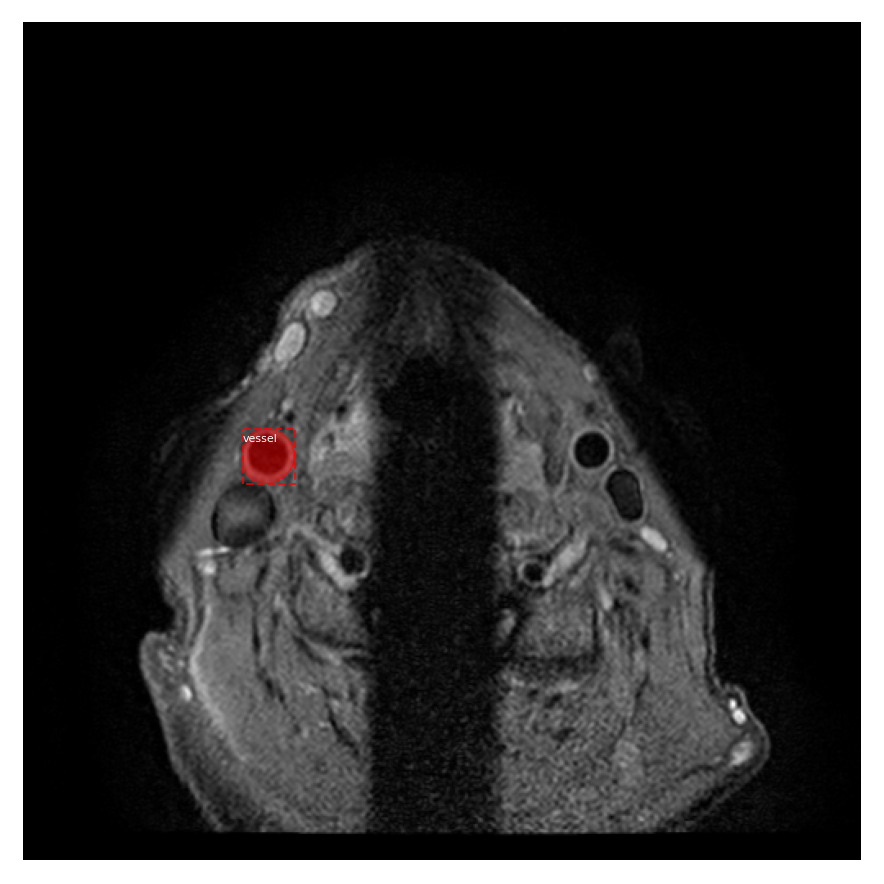

In [34]:
image_id = 0
image = train_set.load_image(image_id)
print(image.shape)
mask, class_ids = train_set.load_mask(image_id)
print(mask.shape)
bbox = extract_bboxes(mask)
display_instances(image, bbox, mask, class_ids, train_set.class_names)

In [36]:
# define a configuration for the model
class PlaqueConfig(Config):
    # define the name of the configuration
    NAME = "plaque_cfg"
    # number of classes (background + plaque)
    NUM_CLASSES = 1 + 1
    # number of training steps per epoch
    STEPS_PER_EPOCH = len(train_set.image_ids)//2
    IMAGE_MAX_DIM = im_side
    IMAGE_MIN_DIM = im_side
    DETECTION_MAX_INSTANCES = 6
    

In [37]:
config = PlaqueConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        6
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES  

In [38]:
model = MaskRCNN(mode='training', model_dir='../res', config=config)
model.load_weights('mask_rcnn_coco.h5', by_name=True, 
                   exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",  "mrcnn_bbox", "mrcnn_mask"])





Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead


In [39]:
results = model.train(train_set, valid_set, 
            learning_rate=config.LEARNING_RATE, 
            epochs=100, 
            layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: ./plaque_cfg20220607T1820\mask_rcnn_plaque_cfg_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4         (Tim

Epoch 18/100
777/777 [==============================] - 662s 852ms/step - loss: 0.1571 - rpn_class_loss: 0.0025 - rpn_bbox_loss: 0.0288 - mrcnn_class_loss: 0.0057 - mrcnn_bbox_loss: 0.0180 - mrcnn_mask_loss: 0.1022 - val_loss: 0.6480 - val_rpn_class_loss: 0.0097 - val_rpn_bbox_loss: 0.1678 - val_mrcnn_class_loss: 0.0336 - val_mrcnn_bbox_loss: 0.1544 - val_mrcnn_mask_loss: 0.2826
Epoch 19/100
777/777 [==============================] - 664s 854ms/step - loss: 0.1502 - rpn_class_loss: 0.0024 - rpn_bbox_loss: 0.0267 - mrcnn_class_loss: 0.0059 - mrcnn_bbox_loss: 0.0172 - mrcnn_mask_loss: 0.0979 - val_loss: 0.5820 - val_rpn_class_loss: 0.0040 - val_rpn_bbox_loss: 0.1451 - val_mrcnn_class_loss: 0.0249 - val_mrcnn_bbox_loss: 0.1183 - val_mrcnn_mask_loss: 0.2896
Epoch 20/100
777/777 [==============================] - 666s 858ms/step - loss: 0.1436 - rpn_class_loss: 0.0024 - rpn_bbox_loss: 0.0247 - mrcnn_class_loss: 0.0058 - mrcnn_bbox_loss: 0.0156 - mrcnn_mask_loss: 0.0951 - val_loss: 0.6247 - 

777/777 [==============================] - 665s 856ms/step - loss: 0.0618 - rpn_class_loss: 0.0012 - rpn_bbox_loss: 0.0060 - mrcnn_class_loss: 0.0021 - mrcnn_bbox_loss: 0.0042 - mrcnn_mask_loss: 0.0483 - val_loss: 0.7884 - val_rpn_class_loss: 0.0103 - val_rpn_bbox_loss: 0.1357 - val_mrcnn_class_loss: 0.0654 - val_mrcnn_bbox_loss: 0.1294 - val_mrcnn_mask_loss: 0.4475
Epoch 61/100
777/777 [==============================] - 680s 876ms/step - loss: 0.0599 - rpn_class_loss: 0.0012 - rpn_bbox_loss: 0.0054 - mrcnn_class_loss: 0.0024 - mrcnn_bbox_loss: 0.0041 - mrcnn_mask_loss: 0.0467 - val_loss: 0.9560 - val_rpn_class_loss: 0.0086 - val_rpn_bbox_loss: 0.1774 - val_mrcnn_class_loss: 0.0826 - val_mrcnn_bbox_loss: 0.1365 - val_mrcnn_mask_loss: 0.5508
Epoch 62/100
777/777 [==============================] - 672s 865ms/step - loss: 0.0607 - rpn_class_loss: 0.0011 - rpn_bbox_loss: 0.0060 - mrcnn_class_loss: 0.0020 - mrcnn_bbox_loss: 0.0041 - mrcnn_mask_loss: 0.0475 - val_loss: 1.0532 - val_rpn_class

In [40]:
model.keras_model.save_weights("../res/mask-rcnn_simple.h5")

In [41]:
class PredictionConfig(Config):
    NAME = "plaque_cfg"
    NUM_CLASSES = 1 + 1
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    

In [42]:
cfg = PredictionConfig()
model = MaskRCNN(mode='inference', model_dir='../res', config=cfg)
model.load_weights("../res/mask-rcnn_simple.h5", by_name=True)


Instructions for updating:
Use `tf.cast` instead.


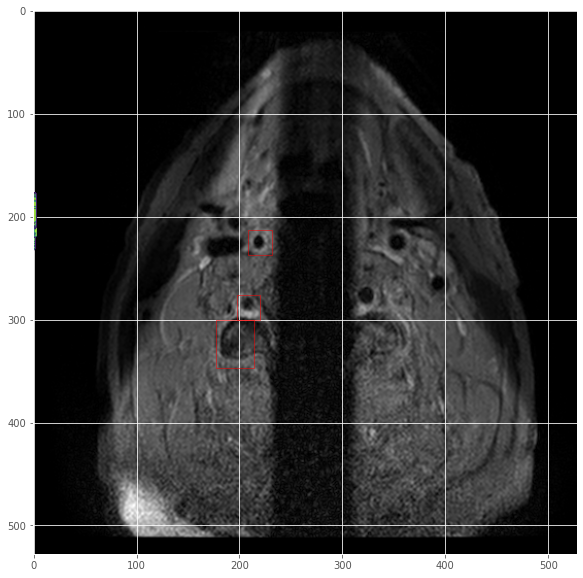

In [74]:
tst_name = img_names_test[10]
tst_dcm = pydicom.read_file(tst_name, force = True)
tst_dcm.file_meta.TransferSyntaxUID = pydicom.uid.ImplicitVRLittleEndian
tst_img = tst_dcm.pixel_array
tst_min = np.min(tst_img)
tst_max = np.max(tst_img)
tst_img_norm = ((tst_img - tst_min)/(tst_max - tst_min)*255).astype(np.uint8)
tst_img_an = np.dstack((tst_img_norm, tst_img_norm, tst_img_norm))

scaled_image = mold_image(tst_img_an, cfg)
sample = expand_dims(scaled_image, 0)
yhat = model.detect(sample, verbose=0)[0]
plt.figure(figsize=(10, 10))
plt.imshow(tst_img_an)
ax = plt.gca()
for box in yhat['rois']:
    y1, x1, y2, x2 = box
    width, height = x2 - x1, y2 - y1
    rect = Rectangle((x1, y1), width, height, fill=False, color='red')
    ax.add_patch(rect)
#for i in range (0, yhat['masks'].shape[2]):
#    plt.contour(yhat['masks'][..., i], colors='r')
for mask in yhat['masks']:
    plt.contour(mask)
plt.show()

## 2. Data augmentation

In [71]:
import albumentations as A

Defining transformations:

In [72]:
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomSizedCrop(min_max_height=(int(im_side*0,75), im_side), height=im_side, width=im_side, p=0.5),
    A.VerticalFlip(p=0.5),
    A.Blur(p=0.5),
    A.GaussNoise(p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.25, contrast_limit=0.25, p=0.5),
    A.RandomGamma(p=0.5)
])

In [75]:
class PlaqueDatasetAug(Dataset):
    # load the dataset definitions
    def load_dataset(self, img_names, n_samples=10):
        self.add_class("dataset", 1, "vessel")
        rs=0
        counter = 0
        
        for impth in img_names:
            
            img = path2array(impth)
            img_min = np.min(img)
            img_max = np.max(img)
            img_norm = ((img - img_min)/(img_max - img_min)*255).astype(np.uint8)
            
            con_name = glob.glob(os.path.join(os.path.split(impth)[0],
                                              'MASSExport')+os.sep+'*'+ impth.split(os.sep)[2][-10:-4]+'*.dcm')[0]
            con = (path2array(con_name)>0).astype(np.uint8)
            
            if (np.sum(con)>0)&((img_max - img_min)>0):
                for smpl in range (0, n_samples):
                    augmented = transform(image=img_norm, mask=con)
                    
                    self.add_image('dataset', 
                                   image_id=impth.split(os.sep)[-2] + '_' + impth.split(os.sep)[-1] + '+' + str(smpl), 
                                   path=impth, 
                                   annotation=con_name, 
                                   img_aug = augmented['image'], 
                                   mask_aug = augmented['mask'])
                rs+=1
 
    # load the masks for an image
    def load_mask(self, image_id):
        info = self.image_info[image_id]
        mask_aug = info['mask_aug'][8:-8, 8:-8, np.newaxis]
        class_id = [self.class_names.index('vessel')]
        return mask_aug, asarray(class_id, dtype='int32')
    
    def load_image(self, image_id):
        info = self.image_info[image_id]
        img_aug = info['img_aug'][8:-8, 8:-8]
        
        return np.dstack((img_aug, img_aug, img_aug))
 
    # load an image reference
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path']

In [76]:
train_set_aug = PlaqueDatasetAug()
train_set_aug.load_dataset(img_names_train)
train_set_aug.prepare()
print('Train: %d' % len(train_set_aug.image_ids))

Train: 15540


In [78]:
valid_set_aug = PlaqueDatasetAug()
valid_set_aug.load_dataset(img_names_valid)
valid_set_aug.prepare()
print('Train: %d' % len(valid_set_aug.image_ids))

Train: 3390


(512, 512, 3)
(512, 512, 1)


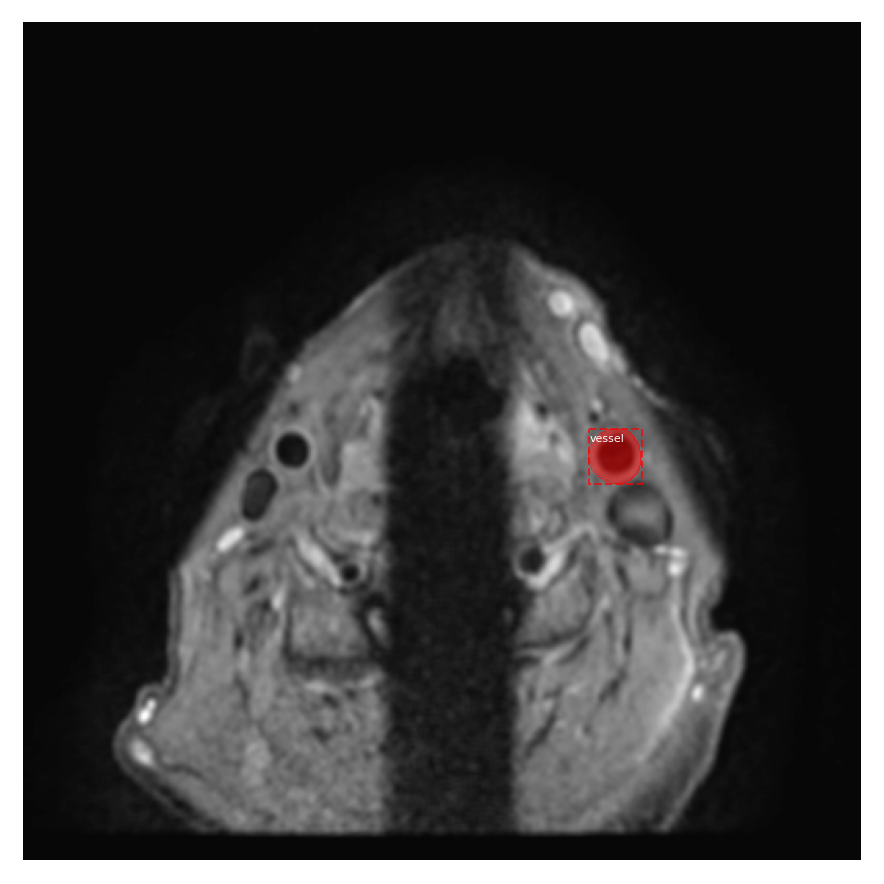

In [77]:
image_id = 0
image = train_set_aug.load_image(image_id)
print(image.shape)
mask, class_ids = train_set_aug.load_mask(image_id)
print(mask.shape)
bbox = extract_bboxes(mask)
display_instances(image, bbox, mask, class_ids, train_set.class_names)

In [81]:
# define a configuration for the model
class PlaqueConfigAug(Config):
    # define the name of the configuration
    NAME = "plaque_cfg"
    # number of classes (background + plaque)
    NUM_CLASSES = 1 + 1
    # number of training steps per epoch
    STEPS_PER_EPOCH = len(train_set_aug.image_ids)//2
    IMAGE_MAX_DIM = im_side
    IMAGE_MIN_DIM = im_side
    DETECTION_MAX_INSTANCES = 6
    VALIDATION_STEPS = 500

In [82]:
config = PlaqueConfigAug()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        6
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES  

In [83]:
model_aug = MaskRCNN(mode='training', model_dir='../res', config=config)
model_aug.load_weights('mask_rcnn_coco.h5', by_name=True, 
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",  "mrcnn_bbox", "mrcnn_mask"])

In [84]:
results_aug = model_aug.train(train_set_aug, valid_set_aug, 
                              learning_rate=config.LEARNING_RATE, 
                              epochs=100, 
                              layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: ./plaque_cfg20220608T1634\mask_rcnn_plaque_cfg_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4         (Tim

7770/7770 [==============================] - 8164s 1s/step - loss: 0.0644 - rpn_class_loss: 0.0011 - rpn_bbox_loss: 0.0094 - mrcnn_class_loss: 0.0017 - mrcnn_bbox_loss: 0.0053 - mrcnn_mask_loss: 0.0468 - val_loss: 0.9727 - val_rpn_class_loss: 0.0151 - val_rpn_bbox_loss: 0.2093 - val_mrcnn_class_loss: 0.0789 - val_mrcnn_bbox_loss: 0.1367 - val_mrcnn_mask_loss: 0.5326
Epoch 41/100
7770/7770 [==============================] - 8079s 1s/step - loss: 0.0636 - rpn_class_loss: 0.0011 - rpn_bbox_loss: 0.0093 - mrcnn_class_loss: 0.0017 - mrcnn_bbox_loss: 0.0051 - mrcnn_mask_loss: 0.0464 - val_loss: 1.0291 - val_rpn_class_loss: 0.0172 - val_rpn_bbox_loss: 0.2325 - val_mrcnn_class_loss: 0.0882 - val_mrcnn_bbox_loss: 0.1420 - val_mrcnn_mask_loss: 0.5492
Epoch 42/100
7770/7770 [==============================] - 8082s 1s/step - loss: 0.0630 - rpn_class_loss: 0.0011 - rpn_bbox_loss: 0.0093 - mrcnn_class_loss: 0.0017 - mrcnn_bbox_loss: 0.0050 - mrcnn_mask_loss: 0.0458 - val_loss: 1.0408 - val_rpn_class

7770/7770 [==============================] - 8187s 1s/step - loss: 0.0436 - rpn_class_loss: 6.1338e-04 - rpn_bbox_loss: 0.0042 - mrcnn_class_loss: 8.2373e-04 - mrcnn_bbox_loss: 0.0026 - mrcnn_mask_loss: 0.0353 - val_loss: 1.2663 - val_rpn_class_loss: 0.0245 - val_rpn_bbox_loss: 0.2188 - val_mrcnn_class_loss: 0.1717 - val_mrcnn_bbox_loss: 0.1457 - val_mrcnn_mask_loss: 0.7056
Epoch 83/100
7770/7770 [==============================] - 8202s 1s/step - loss: 0.0443 - rpn_class_loss: 6.3277e-04 - rpn_bbox_loss: 0.0047 - mrcnn_class_loss: 8.2923e-04 - mrcnn_bbox_loss: 0.0026 - mrcnn_mask_loss: 0.0355 - val_loss: 1.1637 - val_rpn_class_loss: 0.0204 - val_rpn_bbox_loss: 0.1889 - val_mrcnn_class_loss: 0.1492 - val_mrcnn_bbox_loss: 0.1387 - val_mrcnn_mask_loss: 0.6664
Epoch 84/100
7770/7770 [==============================] - 8397s 1s/step - loss: 0.0437 - rpn_class_loss: 6.0324e-04 - rpn_bbox_loss: 0.0042 - mrcnn_class_loss: 7.6497e-04 - mrcnn_bbox_loss: 0.0026 - mrcnn_mask_loss: 0.0355 - val_loss

In [85]:
model_aug.keras_model.save_weights("../res/mask-rcnn_aug.h5")

In [86]:
cfg = PredictionConfig()
model_aug = MaskRCNN(mode='inference', model_dir='../res', config=cfg)
model_aug.load_weights("../res/mask-rcnn_simple.h5", by_name=True)

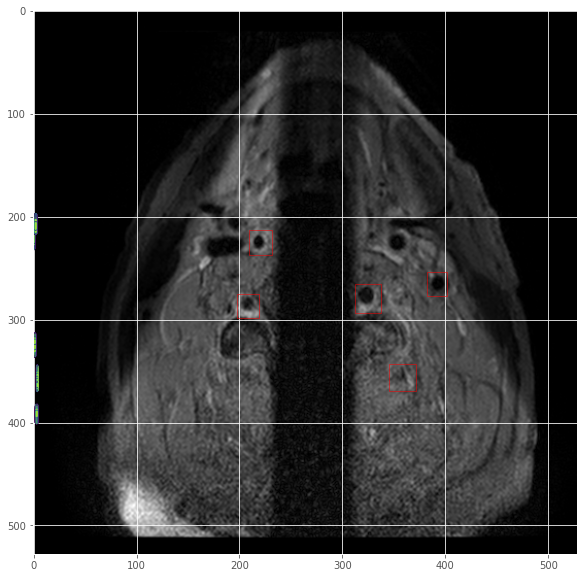

In [87]:
tst_name = img_names_test[10]
tst_dcm = pydicom.read_file(tst_name, force = True)
tst_dcm.file_meta.TransferSyntaxUID = pydicom.uid.ImplicitVRLittleEndian
tst_img = tst_dcm.pixel_array
tst_min = np.min(tst_img)
tst_max = np.max(tst_img)
tst_img_norm = ((tst_img - tst_min)/(tst_max - tst_min)*255).astype(np.uint8)
tst_img_an = np.dstack((tst_img_norm, tst_img_norm, tst_img_norm))

scaled_image = mold_image(tst_img_an, cfg)
sample = expand_dims(scaled_image, 0)

yhat = model_aug.detect(sample, verbose=0)[0]
plt.figure(figsize=(10, 10))
plt.imshow(tst_img_an)
ax = plt.gca()
for box in yhat['rois']:
    y1, x1, y2, x2 = box
    width, height = x2 - x1, y2 - y1
    rect = Rectangle((x1, y1), width, height, fill=False, color='red')
    ax.add_patch(rect)
#for i in range (0, yhat['masks'].shape[2]):
#    plt.contour(yhat['masks'][..., i], colors='r')
for mask in yhat['masks']:
    plt.contour(mask)
plt.show()